In [6]:
# Import useful packages
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir, path
import copy

In [86]:
# Converts a rbg image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    if (len(image.shape) < 3):
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


def load_data(dir_list, image_size): #input [first_class, second_class, etc] and (image_width, image_height)

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        
        # Output is 0 for no, 1 for yes
        y_val = 0
        if directory.endswith('yes'):
            y_val = 1
        
        for filename in listdir(directory):
            # load the image
            #image = cv2.imread(directory + '\\' + filename)
            image = cv2.imread(path.join(directory, filename), cv2.IMREAD_UNCHANGED)
            #image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_NEAREST)
            
            # Convert image to grayscale if necessary
            if len(image.shape) != 2:
                image = rgb2gray(image)
            
            # normalize values
            image = image / 255.
            
            X.append(image)
            y.append(y_val)
            # append a value of 1 to the target array if the image
            '''
            # is in the folder named 'yes', otherwise append 0.
            if directory[0] == 'yes': #for the time being we only have yes/no directories
                y.append([1])
            else: #other option is no aka directory[1]
                y.append([0])
            '''
            
    X = np.array(X)
    y = np.array(y)

    # Shuffle the data for good measure
    X, y = shuffle(X, y)

    #print(f'Number of examples is: {len(X)}')
    #print(f'X shape is: {X.shape}')
    #print(f'y shape is: {y.shape}')

    return X, y

# Split dataset
def split_data(X, y, test_s=0.2):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_s, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [87]:
def build_model(input_shape): # tuple in the shape of  model input ex: (image_width, image_height, #channels)

    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)  # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input)  # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)  # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)  # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X)  # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X)  # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X)  # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')

    return model

In [88]:
# Defining useful variables
dir_list = ['TumorIdentifier/no', 'TumorIdentifier/yes']
image_size = (128, 128)

In [89]:
# Load dataset
X, y = load_data(dir_list, image_size)

In [90]:
# Split dataset (80% train, 10% validation, 10% test)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [91]:
# Build the convolutional network model
model = build_model((image_size[0],image_size[1],1))
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 132, 132, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 126, 126, 32)      1600      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 126, 126, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 31, 31, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 7, 7, 32)  

In [92]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [93]:
%%time

# Train the model (run cell multiple times to loop)
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
10/10 [==============================] - 6s 648ms/step - loss: 0.9616 - accuracy: 0.5196 - mse: 0.3182 - recall_6: 0.3136 - precision_6: 0.3592 - val_loss: 0.6886 - val_accuracy: 0.4211 - val_mse: 0.2478 - val_recall_6: 1.0000 - val_precision_6: 0.4211
Epoch 2/20
10/10 [==============================] - 5s 485ms/step - loss: 0.5241 - accuracy: 0.7712 - mse: 0.1652 - recall_6: 0.7288 - precision_6: 0.6935 - val_loss: 0.6741 - val_accuracy: 0.5526 - val_mse: 0.2406 - val_recall_6: 1.0000 - val_precision_6: 0.4848
Epoch 3/20
10/10 [==============================] - 5s 463ms/step - loss: 0.4378 - accuracy: 0.8137 - mse: 0.1351 - recall_6: 0.7288 - precision_6: 0.7748 - val_loss: 0.6827 - val_accuracy: 0.5263 - val_mse: 0.2450 - val_recall_6: 1.0000 - val_precision_6: 0.4706
Epoch 4/20
10/10 [==============================] - 5s 457ms/step - loss: 0.3634 - accuracy: 0.8529 - mse: 0.1128 - recall_6: 0.8051 - precision_6: 0.8120 - val_loss: 0.6656 - val_accuracy: 0.5789 - val_mse: 

In [94]:
# For plotting the loss and accuracy
history = model.history.history
for key in history.keys():
    print(key)

loss
accuracy
mse
recall_6
precision_6
val_loss
val_accuracy
val_mse
val_recall_6
val_precision_6


In [96]:
y_pred = model.predict_on_batch(X_test)
#print(y_pred)
#print(model.evaluate(X_test, y_pred))

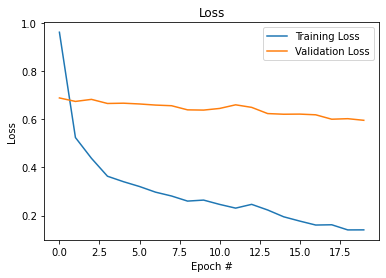

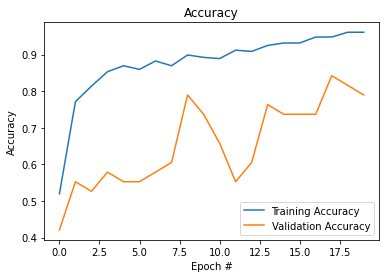

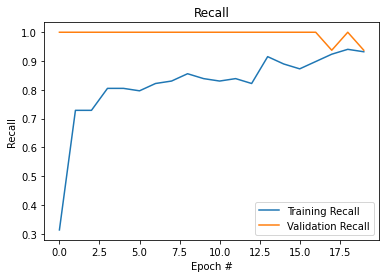

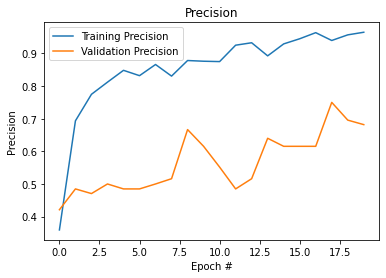

In [97]:
# Function which plots loss, accuracy, recall and precision of the trained model
def plot_metrics(history):

    keys = list(history)
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_recall = history[keys[3]]
    val_recall = history[keys[8]]
    train_precision = history[keys[4]]
    val_precision = history[keys[9]]
    
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Recall
    plt.figure()
    plt.plot(train_recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epoch #')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

    # Precision
    plt.figure()
    plt.plot(train_precision, label='Training Precision')
    plt.plot(val_precision, label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epoch #')
    plt.ylabel('Precision')   
    plt.legend()
    plt.show()

    # Plot loss, accuracy, recall and precision of training and validation data
plot_metrics(history)